# Binary Recurrent Neural Net (RNN)

Now we have the concept of Stacked series, we can see what we can do with them. One thing we might do is run each timestep through a linear layer, a bit like the FeedForward but then, times the number of timesteps. That would give a big matrix output layer of size #Nodes x #Stacked Records. That matrix can be flatten to a single array and used in consequent layers.

Though this does give our Network the ability to see and use all the payments in the series, and though it might actually give OK results, we can intuitively see such model might look for very specific patterns at very specific timestamps and might not really generalize the way we hope.

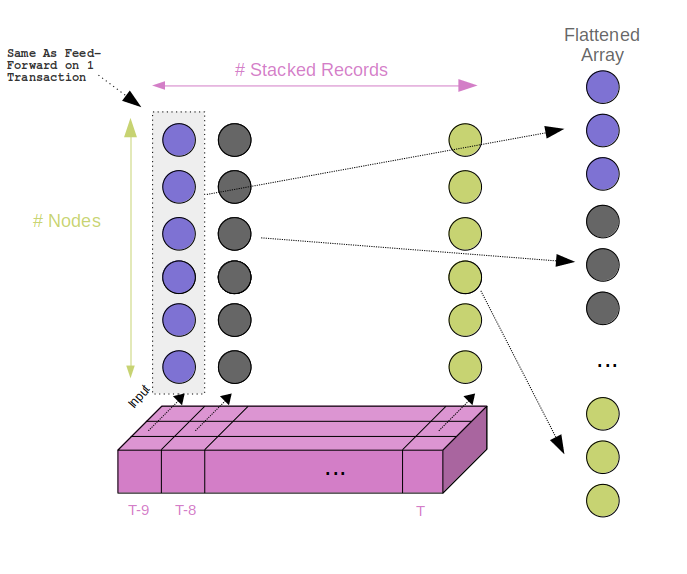

RNN's are an architecture where the RNN Layer 'unfolds' a dimension, in our case the time dimension. At each time step it does not only calculate activations based on the *input*, but also feeds a *hidden state* to the next node. The hidden states can intuitively be seen as proving the next node with input on the previous context, i.e. what happened in the previous steps. This allows the Neural Net to understand sequential data, RNN's are widely used in NLP (Natural Language Processing) were the order and sequence of words tends to be important.

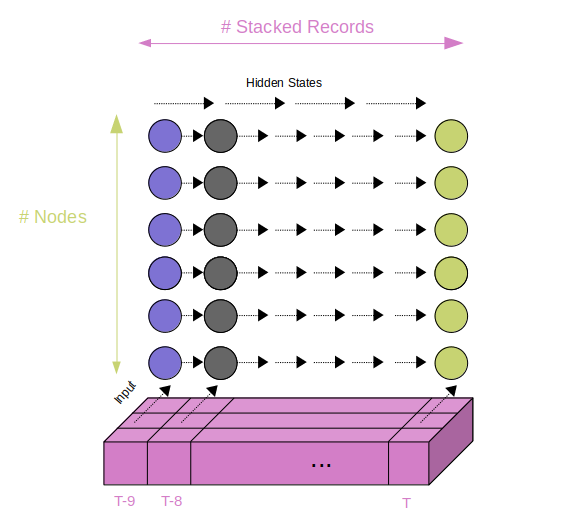

Unfolding the time dimension implies that the Recurrent Layer will 'Step' through the time dimension. It will start at the last time-step, calculate the features and hidden-state. Then it will move along, to the next step, this step had a hidden state and the input of time-step-2 as input, it will calculate the features and next hidden state and move along... and so on until it reaches the end of the time dimension.

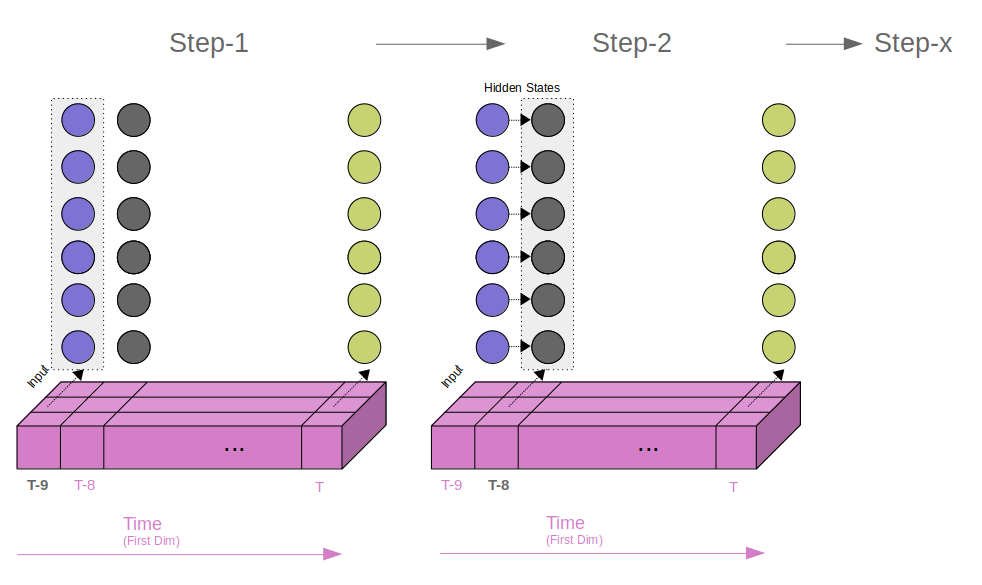

Generic RNN's suffer from vanishing (and exploding) gradients hence have a 'short term memory', they forget about the early elements in the series. `LSTM` (Long Short Term Memory) and `GRU` (Gated Recurrent Units) strive to offer solutions for this, we won't get into the detail of what exactly. They are the RNN's that are used in practice. 
Having said this, there probably is a limit to how many transaction can be fed to an RNN's, some research on the topic might be required, but we probably want to keep this limited to 30, .. 50 or so.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

---
#### Note on computation
Though the embeddings in previous examples did introduce computational strain, LTSM's will take the required __computational power__ a notch up. It's probably best to run this on a fairly recent Nvidia GPU which can leverage 
`CUDA`. If there is not GPU available locally, Google offers free to use Colab notebook that can use GPU's. In total absence of GPU's, The alternative is to be very patient during training.

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount_binned,
        fraud
    ])

amount_oh = ft.FeatureOneHot('amount_one_hot', amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    df = e.from_df(learning_features, df, inference=False)
df

2020-12-03 14:26:34.713 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:26:34.714 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:26:34.714 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:26:34.714 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-03 14:26:34.957 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-03 14:26:34.973 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-03 14:26:34.974 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-03 14:26:34.999 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-03 14:26:35.000 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

,customer,date,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,...,amount_bin__22,amount_bin__23,amount_bin__24,amount_bin__25,amount_bin__26,amount_bin__27,amount_bin__28,amount_bin__29,amount_bin__0,fraud_label
0,C1093826151,2020-01-01,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C352968107,2020-01-01,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C2054744914,2020-01-01,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1760612790,2020-01-01,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C757503768,2020-01-01,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,C1753498738,2020-06-28,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594639,C650108285,2020-06-28,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594640,C123623130,2020-06-28,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594641,C1499363341,2020-06-28,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build Series

In [5]:
## Build Series
with en.EnginePandasNumpy(num_threads=8) as e:
    data_list = e.to_series_stacked(df, learning_features, key_field=customer, time_field=date_time, length=5)
print(data_list.shapes)
print(data_list.dtype_names)

2020-12-03 14:26:39.608 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:26:39.608 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:26:39.609 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:26:39.609 d373c7.engines.panda_numpy     INFO     Start creating stacked series for Tensor Definition <learning> using 8 process(es)
2020-12-03 14:26:45.217 d373c7.engines.panda_numpy     INFO     Returning series of types ['int8', 'int8'].
2020-12-03 14:26:45.218 d373c7.engines.panda_numpy     INFO     Done creating learning. Shapes=[(594643, 5, 107), (594643, 1)]


[(594643, 5, 107), (594643, 1)]
['int8', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [6]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 5, 107), (434643, 1)]
Validation Data shapes [(30000, 5, 107), (30000, 1)]
Test Data shapes [(100000, 5, 107), (100000, 1)]
Done


## Set-up Devices

In [7]:
device, cpu = pt.init_devices()

2020-12-03 14:26:49.947 d373c7.pytorch.common          INFO     Torch Version : 1.7.0
2020-12-03 14:26:50.016 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-03 14:26:50.016 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


## Build the model

> In this example we use a `ReccurentFraudClassifier` model. We give it the TensorDefinition of Learning features, then ask it to build a __LSTM__ style RNN, use *16* recurrent features, *1* recurrent layer and add 1 layer of *8* linear features after that.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)
train_sampler = pt.ClassSampler(learning_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.RecurrentFraudClassifier(
    learning_features, 'LSTM', recurrent_features=16, recurrent_layers=1, linear_layers=[8]
)
print(m)

RecurrentFraudClassifier(
  Number of parameters : 9017
  (head): TensorDefinitionHead(lcs=['Binary'])
  (body): LSTMBody(
    (rnn): LSTM(107, 16, batch_first=True)
  )
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linear(in_features=123, out_features=8, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU(inplace=True)
    )
  )
  (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): SingleClassBinaryOutput(
    (out_block): Sequential(
      (0): Linear(in_features=8, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)


Graphically that models looks like below;

The matrix of input (the stacked transactions) are fed to an `LSTM` layer. In this case the input is (107 binary features of the FeedForward examples x 5). The `LSTM` layer will create 16 features at each timestep. As mentioned, data is forwarded between the layers at the various timestep. We get an output matrix 16 x 5 from the `LSTM`. In DeepLearning we would say a Tensor of shape 16,5.

We take the __last step only__ of that layer (which we can intuitively think of as the last transaction with context from the previous 4 transactions). As the initial FeedForward networks did quite well, we make this layer 'dense' and concatenate the full last payment to the 16 'last' LSTM features. This should allow the model to see the full acutal transaction if that proves interesting. That gives 123 feature that go into the rest of the Network, which is the same as the FeedForward examples.

*(Some layers were omitted for simplicity)*

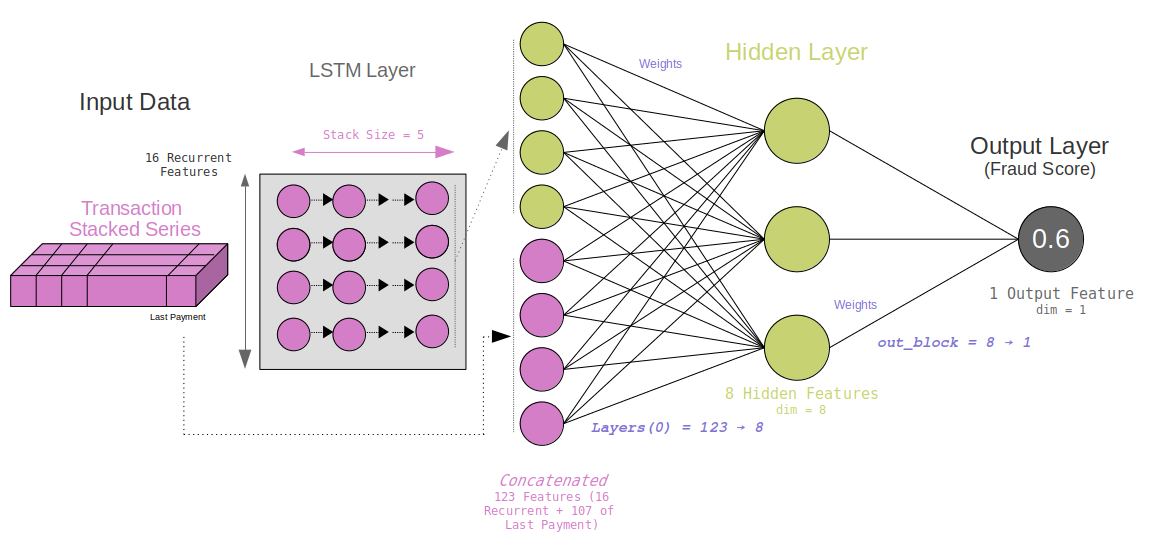

# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-03 14:27:01.819 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 276.38it/s]
2020-12-03 14:27:04.507 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


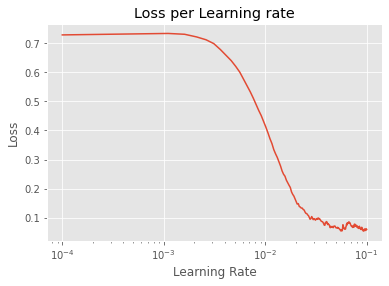

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

> This model behaves fairly OK, but toward the end the validation and training data seem to converge. That is potententially iffy, might be a sign of overfitting. More on this later.


Epoch 010/010: 100%|██████████| 3631/3631 [00:10<00:00, 352.22it/s, train_loss=0.0151, train_acc=0.995, val_loss=0.0194, val_acc=0.995]


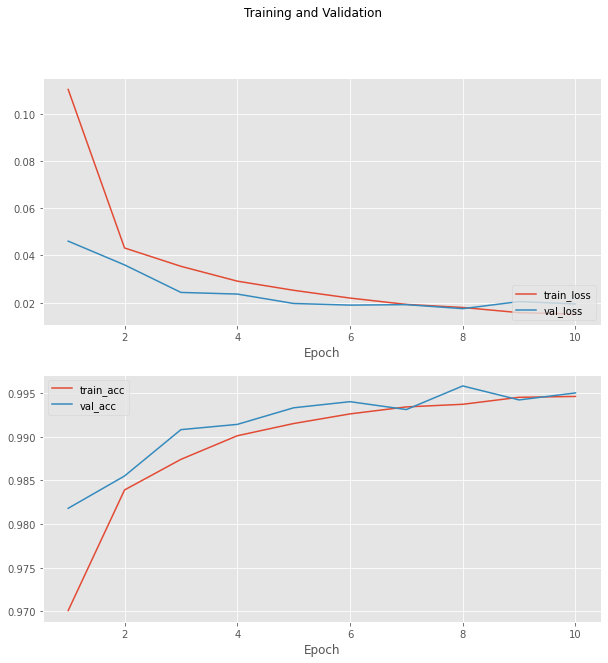

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. Though this model has a worse AUC score than the feedforward, we do see that feeding in the transactional history seems to have given the model a way to get the *False Positive* count better under control. In some cases keeping FP's under control may be preferable to catching all the fraud.

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 737.75it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.75      0.91      0.83      1074

    accuracy                           1.00    100000
   macro avg       0.88      0.95      0.91    100000
weighted avg       1.00      1.00      1.00    100000


auc score : 0.9677
ap score  : 0.9214
-----------------------------------------------------


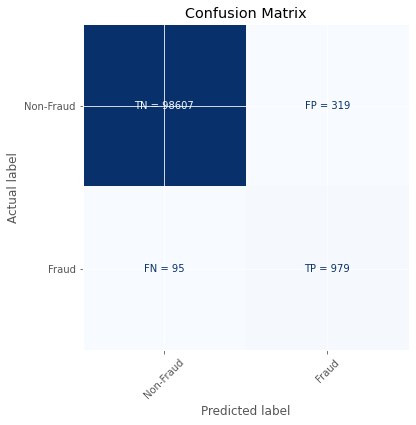

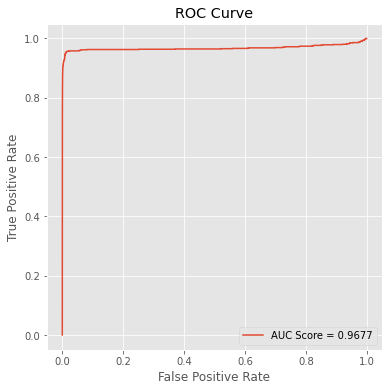

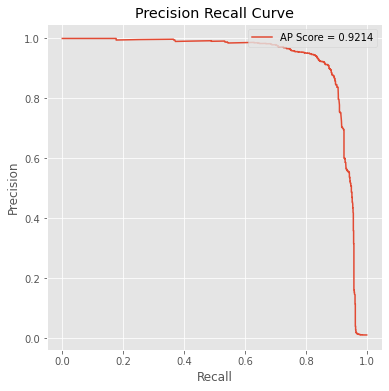

In [11]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

The AUC plot has a weird shape. It flattens out and only reaches the top on the very high scores. It seem this model makes some fairly big mistakes in the extremes. For instance there were 73 transactions were the model thought there was less than 1% chance it would be fraud but it turned out that is was fraud. So there are False Negatives with a very low score, the model got it completely wrong. (See the left spike in below diagram)

It might be interesting to compare this to other models and see if this is overfit. But as mentioned earlier, this data is not ideal, we should maybe not read too much into it.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

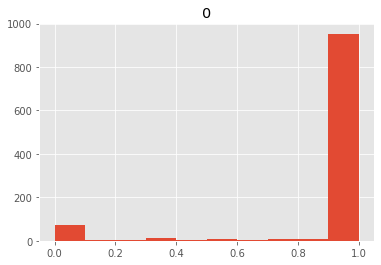

In [12]:
# This plots a histogram of scores for the Fraud records
p = pd.DataFrame(pr[0][pr[1] == 1.0])
p.hist()

# Conclusion
This is a first model using series of transactions. RNN's and LSTM's more specifically are one way to handle series, but there are more. Vision applications tend to use __Convulutional Neural Nets__ (CNN) and since end 2019 __Transformers__ have largely replaced LSTM's in the NLP domain